In [13]:
import math

# helper functions

# subgraph creation, bgpNetwork needs to be established and the provided asn value must be a STRING and present in the graph
def bgpSubgraph(asn):
    subgraphNodes = [asn] + list(bgpNetwork.neighbors(asn))
    subgraph = bgpNetwork.subgraph(subgraphNodes)
    return subgraph


def haversine(lat1, lon1, lat2, lon2):
    # convert coordinates into radian form for calculation
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])

    # get differences
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    return 6371 * c
    

In [14]:
import requests
import random
import time
import aiohttp
import asyncio
import nest_asyncio

#gets rank and cone
def get_caida_as_info(asn):
    url = f"https://api.asrank.caida.org/v2/restful/asns/{asn}"
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        rank = data['data']['asn']['rank']
        cone = data['data']['asn']['customerCone']['numberAsns']
        return rank, cone
    return None, None

# doing the following separately from the above just so the methods are more clear with return
# get latitude and longitude coordinates of an asn
async def get_location(session, asn):
    url = f"https://api.asrank.caida.org/v2/restful/asns/{asn}"
    try:
        async with session.get(url, timeout=aiohttp.ClientTimeout(total=10)) as response:
            if response.status == 200:
                data = await response.json()
                if not data['data']['asn']:
                    return asn, (None, None)
                latitude = data['data']['asn']['latitude']
                longitude = data['data']['asn']['longitude']
                return asn, (latitude, longitude)
    except asyncio.TimeoutError:
        print(f"Timeout while fetching ASN {asn}")
        return asn, "timeout"
    except Exception as e:
        print(f"Error fetching ASN {asn}: {e}")
    return asn, (None, None)

async def fetch_all_locations(asns):
    results = {}
    semaphore = asyncio.Semaphore(10)
    async with aiohttp.ClientSession() as session:
        async def limited(asn):
            async with semaphore:
                return await get_location(session, asn)
                
        tasks = [limited(asn) for asn in asns]
        responses = await asyncio.gather(*tasks)
        for asn, result in responses:
            results[asn] = result
    return results

async def fetch_until_done(all_asns):
    pending = set(all_asns)
    final_results = {}

    while pending:
        results = await fetch_all_locations(pending)

        # Separate successful from timed-out
        pending = set()
        for asn, loc in results.items():
            if loc == "timeout":
                pending.add(asn)
            else:
                final_results[asn] = loc

    return final_results


In [15]:
# read file and create graph

import networkx as nx
import matplotlib.pyplot as plt

# graph representing the bgp network based
bgpNetwork = nx.DiGraph()

with open("bview.20250301.1600.txt", 'r') as file:
    lines = file.readlines()


for line in lines:
    # get the AS path out of the line
    splitLine = line.split("|")
    asPath = splitLine[6]
    pathNodes = asPath.split(" ")

    # need reversed path since path structure is [currentNode, heardFrom, heardFrom... , origin]
    reversedPath = pathNodes[::-1]

    # if this is the origin of the announcement
    if len(reversedPath) == 1:
        bgpNetwork.add_node(reversedPath[0])

    # otherwise we have multiple ASNs we add an edge from i to i + 1 to capture the full route
    else:
        for i in range(len(reversedPath) - 1):
            if not reversedPath[i] == reversedPath[i + 1]:
                # create weighted edge
                bgpNetwork.add_edge(reversedPath[i], reversedPath[i + 1])

print("Graph created")
print(bgpNetwork.number_of_nodes())
print(bgpNetwork.number_of_edges())

Graph created
84009
168808


In [16]:
import pandas as pd
# Node features to input into Machine Learning Algo 

# out-degrees dictionary 
out_degree_dict = dict(bgpNetwork.out_degree())

# in-degrees dictionary
in_degree_dict = dict(bgpNetwork.in_degree())

# degree centrality 
degree_centrality = nx.degree_centrality(bgpNetwork)

# closeness centrality, takes a while but seems resonable time
closeness_centrality = nx.closeness_centrality(bgpNetwork)



# convert to DataFrame for ML
df = pd.DataFrame.from_dict(out_degree_dict, orient='index', columns=['out_degree'])

# to add more columns (features) to the table 
#df['column name'] = values 

df['in_degree'] = in_degree_dict
df['degree_centrality'] = degree_centrality
df['closeness_centrality'] = closeness_centrality

print("Data Frame:")
print(df.head())


Data Frame:
       out_degree  in_degree  degree_centrality  closeness_centrality
749             1          0           0.000012              0.000000
3356           50       6352           0.076207              0.403578
1299           51       2450           0.029771              0.400301
13030           7        801           0.009618              0.353370
2914           36       1482           0.018070              0.367812


2
1


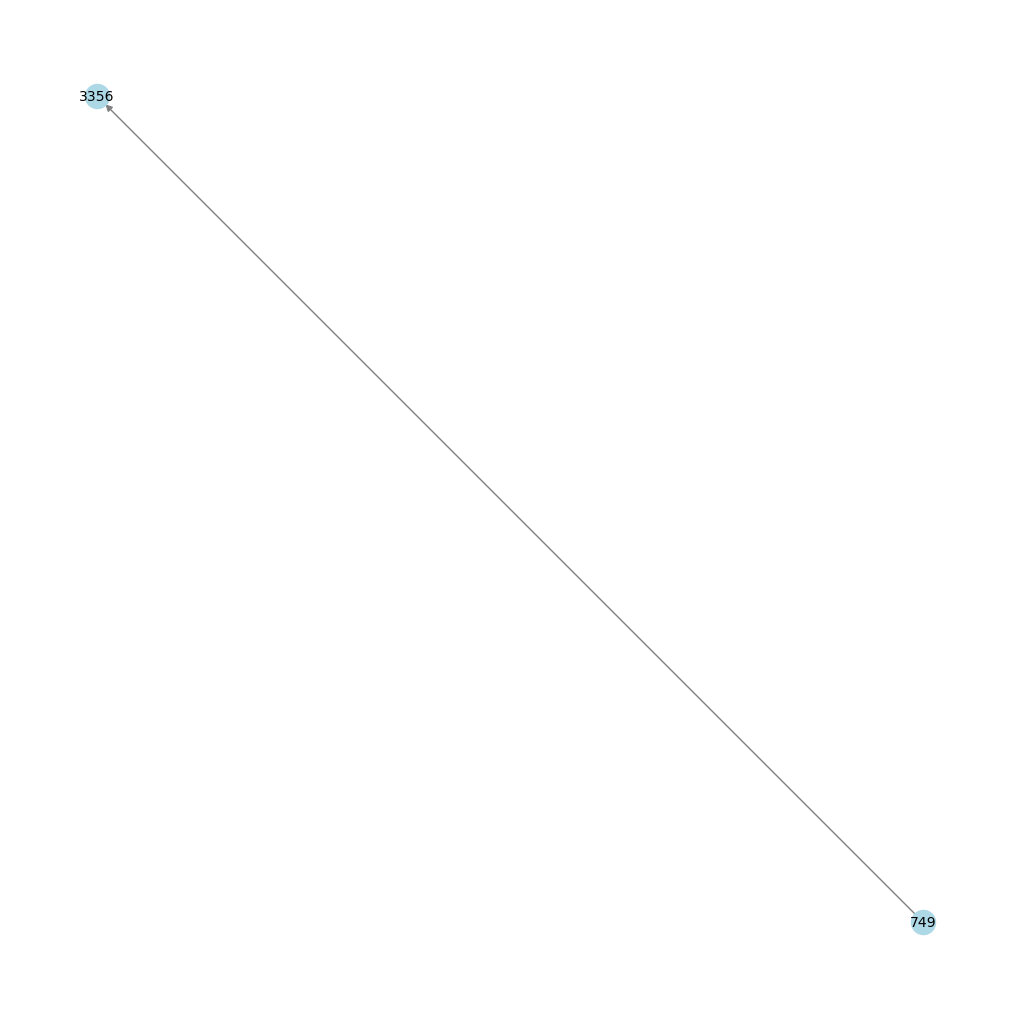

In [17]:
# test use of bgpSubgraph

test = bgpSubgraph("749")
print(test.number_of_nodes())
print(test.number_of_edges())


pos = nx.spring_layout(test, k=0.8)
plt.figure(figsize=(10, 10))
nx.draw(test, pos, with_labels=True, node_color="lightblue", edge_color="gray", font_size=10, arrows=True)
plt.show()

In [18]:
asnLocations = await fetch_until_done(bgpNetwork.nodes())

Timeout while fetching ASN 145984
Timeout while fetching ASN 267529
Timeout while fetching ASN 210514
Timeout while fetching ASN 44447
Timeout while fetching ASN 34272
Timeout while fetching ASN 265985
Timeout while fetching ASN 211081
Timeout while fetching ASN 396911
Timeout while fetching ASN 62824
Timeout while fetching ASN 33728
Timeout while fetching ASN 14544
Timeout while fetching ASN 23339
Timeout while fetching ASN 215940
Timeout while fetching ASN 211301
Timeout while fetching ASN 141486
Timeout while fetching ASN 37381
Timeout while fetching ASN 200006
Timeout while fetching ASN 201742
Timeout while fetching ASN 48187
Timeout while fetching ASN 43913


In [19]:
for key, value in asnLocations.items():
    print(f"{key}: {value}")

146662: (0, 0)
214325: (56.5225108108895, 84.9200771095368)
215588: (49.19, 16.6)
16430: (31.33, -89.34)
49537: (48.86, 2.34)
271005: (-17.1103633580346, -50.0122926144324)
398641: (28.53, -81.41)
202523: (45.44, 12.32)
7588: (13.883588514738, 100.455083061589)
3816: (5.76944774004911, -74.5833627329475)
267539: (-11.04, -45.19)
16117: (60.6829471974494, 17.1148283886596)
23932: (13.6151498860282, 100.648852302299)
64461: (64.54, 40.54)
7560: (35.9843846435957, 127.127093430005)
43951: (59.57, 30.13)
200152: (55.76, 37.66)
27409: (37.78, -79.44)
39891: (23.9105957518386, 44.149986008432)
59890: (47.2295334080664, 9.64312503148869)
12428: (45.4788904877396, 9.18000039322034)
39121: (56.010000101115, 92.875)
61774: (-9.11, -37.12)
328733: (32.87, 13.18)
267635: (-24.9, -53.9)
151527: (-6.19, 106.81)
21752: (42.69, -73.83)
30924: (55.76, 37.66)
272621: (-15.32, -49.12)
34851: (55.76, 37.66)
208530: (51.87, 6.38)
200421: (37.97, -1.14)
203422: (52.22, 20.99)
146570: (0, 0)
265950: (-23.58,

In [20]:
for asn1, asn2 in bgpNetwork.edges():
    lat1, lon1 = asnLocations[asn1]
    lat2, lon2 = asnLocations[asn2]

    if lat1 == None or lat2 == None or lon1 == None or lon2 == None:
        continue

    distance = haversine(lat1, lon1,lat2, lon2)

    bgpNetwork[asn1][asn2]['weight'] = distance
    

In [21]:
# get location if null, lat or long null
# add subteers 
# providers 
# get shortest path based on distances 
# see if shortest path is used in BGP graph 
# look at tiers of path just took, take tier based on connection 
def get_tier(asn):
    url = f"https://api.asrank.caida.org/v2/restful/asns/{asn}"
    try:
        response = requests.get(url, timeout=5)
        if response.status_code == 200:
            data = response.json().get('data', {}).get('asn', {})
            degrees = data.get('asnDegree', {})
            provider = degrees.get('provider', 0)
            peer = degrees.get('peer', 0)
            customer = degrees.get('customer', 0)
            total = degrees.get('total', 0)
            rank = data.get("rank", float('inf'))
            clique = data.get("cliqueMember", False)

            # Tier 1
            if clique and provider == 0 and peer > 100 and customer > 100 and total > 200:
                return 1

            # Tier 2: 
            elif provider > 0 and peer > 50 and customer > 10 and total > 50:
                return 2

            # Tier 3
            else:
                return 3
    except Exception as e:
        print(f"Error ASN {asn}: {e}")
    return None


In [22]:
# label
tier_labels = {}
for asn in df.index[:300]:  # labeling 300 for now
    tier = get_tier(asn)
    if tier:
        tier_labels[asn] = tier

df['tier'] = df.index.map(tier_labels)

 # todo check how many dropped
df = df.dropna(subset=['tier'])
df['tier'] = df['tier'].astype(int)

print(df['tier'].value_counts())


3    204
2     92
1      3
Name: tier, dtype: int64


In [ ]:
# 70% training, 30 testing 

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

X = df[['out_degree', 'in_degree', 'degree_centrality', 'closeness_centrality']]
y = df['tier']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

# train 
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# make prediction
y_pred = model.predict(X_test)

#compare predicton to actual label 
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           1       0.00      0.00      0.00         1
           2       0.64      0.75      0.69        28
           3       0.89      0.82      0.85        61

    accuracy                           0.79        90
   macro avg       0.51      0.52      0.51        90
weighted avg       0.80      0.79      0.79        90



In [24]:
unique = df.index.unique()
print(f"Unique: {len(unique)}")



Unique: 299


In [25]:
# class weight balanced

# 70% training, 30 testing 

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

X = df[['out_degree', 'in_degree', 'degree_centrality', 'closeness_centrality']]
y = df['tier']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

# train 
model = RandomForestClassifier(class_weight='balanced', random_state=42)
model.fit(X_train, y_train)

# make prediction
y_pred = model.predict(X_test)

#compare predicton to actual label 
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         1
           2       0.62      0.75      0.68        28
           3       0.88      0.80      0.84        61

    accuracy                           0.78        90
   macro avg       0.50      0.52      0.51        90
weighted avg       0.79      0.78      0.78        90



/opt/anaconda3/envs/comp142_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/comp142_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/comp142_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le

In [31]:
# 70% training, 30% testing

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Feature matrix and labels
X = df[['out_degree', 'in_degree', 'degree_centrality', 'closeness_centrality']]
y = df['tier']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

# Define hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
    'class_weight': ['balanced']
}

# Perform grid search with 5-fold cross-validation
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=2,
    scoring='f1_macro',
    n_jobs=-1
)

# Fit model
grid_search.fit(X_train, y_train)

# Use best model found
model = grid_search.best_estimator_

# Make predictions
y_pred = model.predict(X_test)

# Compare prediction to actual label
print(classification_report(y_test, y_pred))
print("Best hyperparameters:", grid_search.best_params_)


              precision    recall  f1-score   support

           1       0.00      0.00      0.00         1
           2       0.62      0.82      0.71        28
           3       0.92      0.79      0.85        61

    accuracy                           0.79        90
   macro avg       0.51      0.54      0.52        90
weighted avg       0.82      0.79      0.80        90

Best hyperparameters: {'class_weight': 'balanced', 'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 100}


In [33]:
# 70% training, 30% testing

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report
from xgboost import XGBClassifier

# Feature matrix and labels
X = df[['out_degree', 'in_degree', 'degree_centrality', 'closeness_centrality']]
y = df['tier'] - 1


# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

# Define hyperparameter grid for XGBoost
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Perform grid search with 5-fold cross-validation
grid_search = GridSearchCV(
    estimator=XGBClassifier(
        eval_metric='mlogloss',
        objective='multi:softmax',  # Predict tier labels directly
        random_state=42
    ),
    param_grid=param_grid,
    cv=2,
    scoring='f1_macro',
    n_jobs=-1
)

# Fit model
grid_search.fit(X_train, y_train)

# Use best model found
model = grid_search.best_estimator_

# Make predictions
y_pred = model.predict(X_test)

# Compare prediction to actual label
print(classification_report(y_test, y_pred))
print("Best hyperparameters:", grid_search.best_params_)


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.61      0.82      0.70        28
           2       0.90      0.77      0.83        61

    accuracy                           0.78        90
   macro avg       0.50      0.53      0.51        90
weighted avg       0.80      0.78      0.78        90

Best hyperparameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}


/opt/anaconda3/envs/comp142_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/comp142_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/comp142_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le

In [34]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report
from lightgbm import LGBMClassifier

# Feature matrix and adjusted labels (optional: subtract 1 for consistency with other models)
X = df[['out_degree', 'in_degree', 'degree_centrality', 'closeness_centrality']]
y = df['tier']  # No need to subtract 1 for LGBM

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

# Hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1],
    'class_weight': ['balanced']
}

# Grid search
grid_search = GridSearchCV(
    estimator=LGBMClassifier(random_state=42),
    param_grid=param_grid,
    cv=2,  # safer for small classes
    scoring='f1_macro',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)
model = grid_search.best_estimator_

# Predict + report
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print("Best hyperparameters:", grid_search.best_params_)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001378 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 114
[LightGBM] [Info] Number of data points in the train set: 104, number of used features: 4
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001518 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001361 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 114[LightGBM] [Info] Total Bins 110

[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Number of data points in the train set: 104, number of used features: 4
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of